# Pendulum Network

Here I'll investigate the capabilities of NNs to learn phase transitions when trained in only on phase. Concretely, I'll train a network to solve the simple pendulum ODE on the periodic regime, and analyze how much data it needs to generalize to the non-periodic regime.

In [173]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

### Basic setup

In [2]:
def RK_method(F, t0, x0, h, n_steps, a, b, c):
    dim = len(x0)
    l = len(b)
    t = np.arange(t0, t0 + h*n_steps, h)
    x = np.zeros((n_steps, dim))
    x[0] = x0
    k = np.zeros((l, dim))

    for n in range(1, n_steps):
        k[0] = F(t[n-1], x[n-1])
        for i in range(1, l):
            t_i = t[n-1] + h * c[i]
            x_i = x[n-1] + h * np.dot(a[i-1][:i], k[:i])
            k[i] = F(t_i, x_i)
        x[n] = x[n-1] + h * np.dot(b, k)

    return t, x

# Classical (4-stage) Runge-Kutta
def RK4(F, t0, x0, h, n_steps):
    a = np.array(
        [[0.5, 0, 0],
         [0, 0.5, 0],
         [0, 0, 1]]
    )
    b = np.array([1/6, 2/6, 2/6, 1/6])
    c = np.array([0, 0.5, 0.5, 1])
    return RK_method(F, t0, x0, h, n_steps, a, b, c)

In [3]:
def pendulum(t, X):
	x, v = X
	Dx = v
	Dv = -np.sin(x)
	return np.array([Dx, Dv])

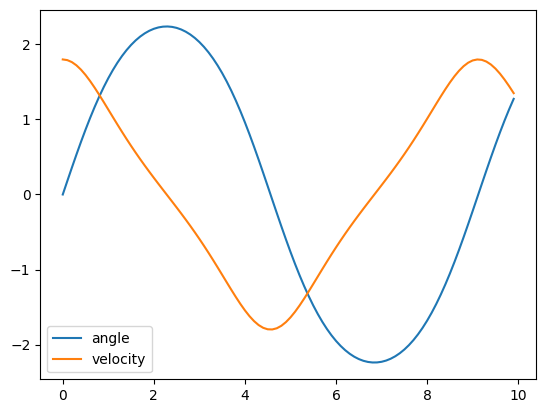

In [119]:
eps = 1e-4
t0 = 0
x0 = np.array([0, 1.8])
h = 0.1
n_steps = 100
t, X = RK4(pendulum, t0, x0, h, n_steps)
plt.plot(t, X[:, 0], label="angle")
plt.plot(t, X[:, 1], label="velocity")
plt.legend()
plt.show()

Plot vector field

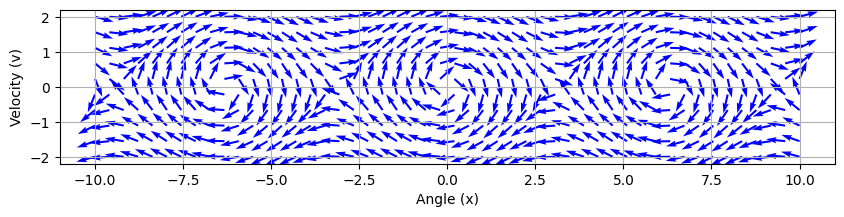

In [57]:
x = np.linspace(-10, 10, 50)
v = np.linspace(-2, 2, 10)
X, V = np.meshgrid(x, v)
dX = V / np.sqrt(V**2 + np.sin(X)**2)
dV = -np.sin(X) / np.sqrt(V**2 + np.sin(X)**2)

plt.figure(figsize=(10, 2))
plt.quiver(X, V, dX, dV, color='b')
plt.xlabel("Angle (x)")
plt.ylabel("Velocity (v)")
plt.grid(True)
plt.show()

### AI time

Both empirically and theoretically, if we start at 'x = 0' the threshold between periodic and aperiodic solution is '|v| = 2'. So let's train the network with datapoints collected from initial conditions with '|v| < 2'. They can all start at x = 0, since all that matters for the network is the tuples (x, x + dx).

Here's how we'll structure the data: (x, y) will be many random pairs of the form ((x,v), (x+dx,v+dv)). I'll generate them by sampling many v's from Unif(0, 1.8) and computing many solutions with initial condition [0, v].

In [210]:
N_VELS = 128
H = 0.1
N_STEPS = 128
THRESHOLD = 1.8

Note that I'm only generating non-negative v's, but that's not a problem since v goes through the entire range of values [-THRES, THRES] in the solution, so we'll have data for the negative values too.

In [211]:
vels = THRESHOLD * np.random.rand((N_VELS))
sols = [torch.from_numpy(RK4(pendulum, 0, np.array([0, vels[n]]), H, N_STEPS)[1]).to(torch.float32) for n in range(N_STEPS)]

In [212]:
# List of tuples of type (X[n], X[n+1])
in_n_out = []
for v in range(N_STEPS): # Iterate through solutions of varying 'v'
	for n in range(N_STEPS-1): # Iterate within solution
		# Create tuple
		data = (sols[v][n], sols[v][n+1])
		in_n_out.append(data)

In [213]:
# We need to create out own Dataset class
class PendulumDataset(Dataset):
	def __init__(self, tuples_list):
		self.data = tuples_list

	def __len__(self):
		return len(self.data)
	
	def __getitem__(self, idx):
		input, output = self.data[idx]
		return input, output

In [214]:
# Create dataset and dataloader
dataset = PendulumDataset(in_n_out)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [215]:
# Create network class
class PendulumNetwork(nn.Module):
	def __init__(self):
		super().__init__()
		self.network = nn.Sequential(
			nn.Linear(2, 64),
			nn.ReLU(),
			nn.Linear(64, 64),
			nn.ReLU(),
			nn.Linear(64, 2)
		)

	def forward(self, x):
		logits = self.network(x)
		return logits

In [216]:
# Hyperparameters
lr = 3e-4
wd=1e-4
n_epochs = 10

In [217]:
# Define network, loss function and optimizer
model = PendulumNetwork()
loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

In [219]:
def train_loop(model, loss_fn, optimizer, dataloader, n_epochs):
	for epoch in range(n_epochs):
		print(f"epoch {epoch+1}-------------------")
		for i, batch in enumerate(dataloader):
			# Get data and compute prediction
			x, y = batch
			pred = model(x)

			# Compute loss and optimize
			loss = loss_fn(y, pred)
			print(f"loss: {loss}")
			loss.backward()
			optimizer.step()
			optimizer.zero_grad()

train_loop(model, loss_fn, optimizer, dataloader, n_epochs)

epoch 1-------------------
loss: 0.47670409083366394
loss: 0.6237074732780457
loss: 0.7393216490745544
loss: 0.5267637968063354
loss: 0.6007568836212158
loss: 0.6217350363731384
loss: 0.4665718078613281
loss: 0.5469377636909485
loss: 0.5841475129127502
loss: 0.6509206295013428
loss: 0.5121180415153503
loss: 0.42759013175964355
loss: 0.6478226780891418
loss: 0.5753298997879028
loss: 0.5193201303482056
loss: 0.5615816712379456
loss: 0.5701711773872375
loss: 0.4864327311515808
loss: 0.5751829743385315
loss: 0.48540180921554565
loss: 0.5061233639717102
loss: 0.42017102241516113
loss: 0.45685720443725586
loss: 0.4809815585613251
loss: 0.37496283650398254
loss: 0.4627569019794464
loss: 0.5274719595909119
loss: 0.4792253375053406
loss: 0.4053765833377838
loss: 0.4655013680458069
loss: 0.45085233449935913
loss: 0.4198852479457855
loss: 0.40974926948547363
loss: 0.5559179186820984
loss: 0.3686804473400116
loss: 0.3638775646686554
loss: 0.39163604378700256
loss: 0.3680573105812073
loss: 0.421073